# SupermarQ

In [32]:
import os
import cirq

import supermarq
import cirq_superstaq

## Setup
SupermarQ is built atop the `cirq_superstaq` framework (see the GitHub repo [here](https://github.com/SupertechLabs/cirq-superstaq)). This means that most of the
details necessary for submitting circuits to various backends are automatically handled
by this package and SupermarQ can offer a simple, clean interface to the user (see the GitHub repo [here](https://github.com/SupertechLabs/SupermarQ)).

Note that we use `cirq_superstaq` in this tutorial purely for convenience. The SupermarQ benchmark
suite is only concerned with the generation of quantum benchmarks and evaluating performance given
a collection of measurement results. The actual process of collecting those results are entirely
separate from SupermarQ which means that any framework for accessing a quantum computer and executing
circuits can be used with this benchmark suite.

### Service Initialization
The first thing we will need is a `cirq_superstaq.Service` which will allow us
to enter our Super.tech api keys as well as any IBM access tokens we may have
available separately.

You will want to set the appropriate API keys beforehand. You can sign in to get your SuperstaQ API key [here](https://superstaq.super.tech).
Your IBM token is available at [https://quantum-computing.ibm.com](https://quantum-computing.ibm.com).

You can set these variables by commenting out the code in the next block:

In [33]:
#os.environ['SUPERSTAQ_API_KEY'] = 'your key here'
#os.environ['IBM_API_KEY'] = 'your key here'

In [35]:
superstaq_api_key = os.environ.get('SUPERSTAQ_API_KEY')
ibm_token = os.environ.get('IBM_API_KEY')

In [36]:
service = cirq_superstaq.Service(
    api_key=superstaq_api_key,
    verbose=True,
)
service.ibmq_set_token(ibm_token)
print(service.get_balance())
print(service.get_backends())

$373.55
{'compile-only': ['aqt_keysight_qpu', 'sandia_qscout_qpu', 'neutral_atom_qpu', 'hqs_lt-s1-apival_qpu', 'hqs_lt-s1_simulator', 'hqs_lt-s1_qpu', 'hqs_lt-s2_qpu'], 'compile-and-run': ['ibmq_qasm_simulator', 'ibmq_armonk_qpu', 'ibmq_santiago_qpu', 'ibmq_bogota_qpu', 'ibmq_lima_qpu', 'ibmq_belem_qpu', 'ibmq_quito_qpu', 'ibmq_statevector_simulator', 'ibmq_mps_simulator', 'ibmq_extended-stabilizer_simulator', 'ibmq_stabilizer_simulator', 'ibmq_manila_qpu', 'ibmq_montreal_qpu', 'ibmq_toronto_qpu', 'ibmq_mumbai_qpu', 'ibmq_guadalupe_qpu', 'ibmq_brooklyn_qpu', 'ibmq_jakarta_qpu', 'ibmq_hanoi_qpu', 'ibmq_lagos_qpu', 'ibmq_cairo_qpu', 'ibmq_auckland_qpu', 'ibmq_perth_qpu', 'ibmq_washington_qpu', 'aws_sv1_simulator', 'aws_tn1_simulator', 'oxford_lucy_qpu', 'd-wave_advantage-system4.1_qpu', 'aws_dm1_simulator', 'd-wave_dw-2000q-6_qpu', 'ionq_ion_qpu', 'rigetti_aspen-m-1_qpu', 'aqt_keysight_qpu', 'sandia_qscout_qpu', 'neutral_atom_qpu', 'hqs_lt-s1-apival_qpu', 'hqs_lt-s1_simulator', 'hqs_lt-s

#### Testing that our Service is working properly

In [11]:
qubits = cirq.LineQubit.range(2)
circuit = cirq.Circuit(cirq.H(qubits[0]), cirq.CNOT(qubits[0], qubits[1]), cirq.measure(*qubits))
print(circuit)

job = service.create_job(circuit=circuit, repetitions=100, target="ibmq_santiago_qpu")
print("We created a job:", job.status())

0: ───H───@───M───
          │   │
1: ───────X───M───
We created a job: Queued


In [33]:
print(job.job_id())
job.status()

414daec8-2376-43c2-b027-73e9c0787ea3


'Queued'

In [23]:
# Load a previously executed job
previous_job_id = '414daec8-2376-43c2-b027-73e9c0787ea3'
job = service.get_job(previous_job_id)
print(job.status())
print(job.counts())

Done
{'00': 40, '10': 5, '01': 1, '11': 54}


## Benchmark creation

Each benchmark class supports a `circuit()` and `score()` function that is used to generate the benchmark circuit and 
post-process the measured counts into a performance metric.

Benchmark-specific features, such as number of qubits, number of layers in the circuit, initial states, etc. are set during
initialization by passing these into the `__init__()` function.

In [16]:
nq = 3
?supermarq.mermin_bell.MerminBell
merminbell = supermarq.benchmarks.mermin_bell.MerminBell(nq)

Init signature: supermarq.mermin_bell.MerminBell(num_qubits: int) -> None
Docstring:     
The Mermin-Bell benchmark is a test of a quantum computer's ability
to exploit purely quantum phenomemna such as superposition and entanglement.
It is based on the famous Bell-inequality tests of locality.

Performance is based on a QPU's ability to prepare a GHZ state and measure
the Mermin operator.
File:           ~/Workspace/SuperTech/SupermarQ_Tutorial/SupermarQ/supermarq/benchmarks/mermin_bell.py
Type:           type
Subclasses:     


In [17]:
print(merminbell)
?merminbell.circuit

Signature: merminbell.circuit() -> cirq.circuits.circuit.Circuit
Docstring: Returns the quantum circuit corresponding to the current benchmark parameters.
File:      ~/Workspace/SuperTech/SupermarQ_Tutorial/SupermarQ/supermarq/benchmarks/mermin_bell.py
Type:      method


In [18]:
merminbell_circuit = merminbell.circuit()
print(merminbell_circuit)

0: ───Rx(-0.5π)───@───────────@───────X───X───S───@───H───────M───
                  │           │       │   │       │           │
1: ───────────────X───@───H───┼───@───┼───@───────@───S───H───M───
                      │       │   │   │                       │
2: ───────────────────X───H───X───X───@───S───H───────────────M───


## Feature vector generation

In [19]:
con = supermarq.features.compute_connectivity(merminbell_circuit)
liv = supermarq.features.compute_liveness(merminbell_circuit)
par = supermarq.features.compute_parallelism(merminbell_circuit)
mea = supermarq.features.compute_measurement(merminbell_circuit)
ent = supermarq.features.compute_entanglement(merminbell_circuit)
dep = supermarq.features.compute_depth(merminbell_circuit)
feature_vecs = [con, liv, par, mea, ent, dep]
print(feature_vecs)

[1.0, 0.6666666666666666, 0.1875, 0.0, 0.4375, 1.0]


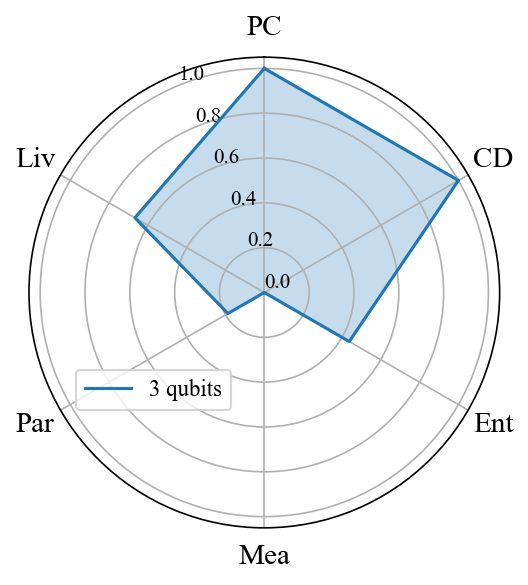

In [20]:
spoke_labels = ['PC', 'Liv', 'Par', 'Mea', 'Ent', 'CD']
supermarq.feature_plotting.plot_benchmark(['MerminBell', [f'{nq} qubits'], [feature_vecs]], spoke_labels=spoke_labels, legend_loc=(0.1, 0.25))

## Execution

In [22]:
# Submit the job
merminbell_job = service.create_job(circuit=merminbell_circuit, repetitions=2000, target='ibmq_santiago_qpu')
print(f'Job {merminbell_job.job_id()} created, current status: {merminbell_job.status()}')

Job a17539ab-342a-4fda-a781-34f70d602b22 created, current status: Queued


In [27]:
# Wait for the job to complete...
print(f'Current status: {merminbell_job.status()}')

Current status: Done


In [29]:
# Collect the results
counts = merminbell_job.counts()
print(counts)

{'000': 229, '100': 78, '010': 41, '110': 124, '001': 1242, '101': 105, '011': 72, '111': 109}


## Evaluation

In [30]:
?merminbell.score

Signature: merminbell.score(counts: collections.Counter) -> float
Docstring:
Compute the score for the N-qubit Mermin-Bell benchmark.

This function assumes the regular big endian ordering of bitstring results
File:      ~/Workspace/SuperTech/SupermarQ_Tutorial/SupermarQ/supermarq/benchmarks/mermin_bell.py
Type:      method


In [31]:
merminbell.score(counts)

0.7795